# Quantum computation for robot posture optimization

* This tutorial proposes a novel quantum computing approach to solving the inverse kinematics problem of a robotic arm [[1](#QOA)]. The method performs forward kinematics—computing the end-effector position from given joint angles—using a quantum circuit, and then feeds the result into a **classical optimization algorithm** to find the joint angles that minimize the error with respect to a target position. By adopting this **hybrid framework** that combines quantum and classical computation, the aim is to efficiently solve inverse kinematics.

* The algorithm is based on variational optimization methods similar to the Variational Quantum Eigensolver (VQE) and the Quantum Approximate Optimization Algorithm (QAOA). The quantum circuit performs the forward kinematics, while the classical optimizer—COBYLA (Constrained Optimization BY Linear Approximation)—evaluates the error and updates the parameters iteratively. This classical optimization loop provides flexibility to incorporate additional objective terms such as energy minimization or obstacle avoidance.

* The proposed quantum circuit ansatz represents each robotic link using one qubit. The orientation of each link is encoded on the Bloch sphere using single-qubit rotation gates (RX, RY, RZ). The expectation values $(⟨X⟩, ⟨Y⟩, ⟨Z⟩)$ are multiplied by the corresponding link lengths to compute the end-effector position. Furthermore, an entangled circuit structure using RXX, RYY, and RZZ gates is introduced, capturing the parent–child link dependencies in orientation. This entanglement enhances both convergence speed and solution accuracy.

This method is implemented on Qmod and validated through both simulation and real quantum hardware. The results demonstrate that introducing entanglement enables faster and more accurate inverse kinematics solutions compared to unentangled cases, thereby confirming the effectiveness of quantum computation in robotic applications.


In [1]:
import math

import matplotlib.pyplot as plt
import numpy as np
import scipy
from tqdm import tqdm

from classiq import *

# Ansatz circuit without entanglement

In [2]:
@qfunc
def q0_rotate(theta: CArray[CReal], q0: QBit):
    RZ(theta[2], q0)
    RY(theta[1], q0)
    RX(theta[0], q0)


@qfunc
def q1_rotate(theta: CArray[CReal], q1: QBit):
    RZ(theta[5], q1)
    RY(theta[4], q1)
    RX(theta[3], q1)


@qfunc
def pauli_Y_measure(q: QArray):
    S(q[0])
    H(q[0])
    S(q[1])
    H(q[1])


def main_project_measure(pauli_term):
    @qfunc
    def main(theta: CArray[CReal, 6], q: Output[QArray[QBit, 2]]):
        allocate(q)
        q0_rotate(theta, q[0])
        q1_rotate(theta, q[1])
        q0_rotate(theta, q[1])
        if pauli_term == "Z":
            pass
        elif pauli_term == "X":
            H(q[0])
            H(q[1])
        elif pauli_term == "Y":
            pauli_Y_measure(q)

    return main

In [4]:
qmod = create_model(main_project_measure("Y"))
write_qmod(qmod, "posture_optimization")
qprog = synthesize(qmod)

In [5]:
show(qprog)

Quantum program link: https://platform.classiq.io/circuit/36pWVSeOsQDhSnq57rtTm14J45R


## Post Processing

In [6]:
NUM_SHOTS = 1000
MAX_ITERATIONS = 30
DOF = 6
# robot link
L1, L2 = 1.0, 1.0
target_pos = np.array([0.6, 1.0, 0.2])

In [7]:
initial_params = (np.linspace(0, 1, DOF)) * math.pi
print(initial_params)

[0.         0.62831853 1.25663706 1.88495559 2.51327412 3.14159265]


## Create cost function

Target position $(X,Y,Z) = (0.6,1.0,0.2)$

### Pauli based measurment

In [8]:
# X pauli measurment
qmod_X = create_model(main_project_measure("X"))
qprog_X = synthesize(qmod_X)
# Y pauli measurment
qmod_Y = create_model(main_project_measure("Y"))
qprog_Y = synthesize(qmod_Y)
# Z pauli measurment
qmod_Z = create_model(main_project_measure("Z"))
qprog_Z = synthesize(qmod_Z)

In [9]:
es_X = ExecutionSession(
    qprog_X, execution_preferences=ExecutionPreferences(num_shots=NUM_SHOTS)
)
es_Y = ExecutionSession(
    qprog_Y, execution_preferences=ExecutionPreferences(num_shots=NUM_SHOTS)
)
es_Z = ExecutionSession(
    qprog_Z, execution_preferences=ExecutionPreferences(num_shots=NUM_SHOTS)
)

In [10]:
def expected_valu(counts):
    expect_value_qubit0 = (
        (counts.get("00", 0) + counts.get("01", 0))
        - (counts.get("10", 0) + counts.get("11", 0))
    ) / NUM_SHOTS
    expect_value_qubit1 = (
        (counts.get("00", 0) + counts.get("10", 0))
        - (counts.get("01", 0) + counts.get("11", 0))
    ) / NUM_SHOTS
    return expect_value_qubit0, expect_value_qubit1

In [11]:
cost_trace = []
cost_trace = []


def evaluate_params(es_X, es_Y, es_Z, params):
    X_sample = es_X.sample(parameters={"theta": params.tolist()})
    Y_sample = es_Y.sample(parameters={"theta": params.tolist()})
    Z_sample = es_Z.sample(parameters={"theta": params.tolist()})
    X0_expect, X1_expect = expected_valu(X_sample.counts)
    Y0_expect, Y1_expect = expected_valu(Y_sample.counts)
    Z0_expect, Z1_expect = expected_valu(Z_sample.counts)
    # location of QOA
    v0 = np.array([X0_expect, Y0_expect, Z0_expect])
    v1 = np.array([X1_expect, Y1_expect, Z1_expect])
    # final output
    estimate_pos = L1 * v0 + L2 * v1
    cost_estimation = np.sum((target_pos - estimate_pos) ** 2)
    cost_trace.append(float(cost_estimation))
    return cost_estimation

Optimization Progress:  50%|████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                            | 15/30 [01:53<01:53,  7.54s/it]

Optimized parameters: [0.5538562527520599, 0.5180382038302478, 2.6520717446034245, 1.6766637933338149, 3.93410941527406, 4.178340080781159]


Text(0.5, 1.0, 'Cost convergence')

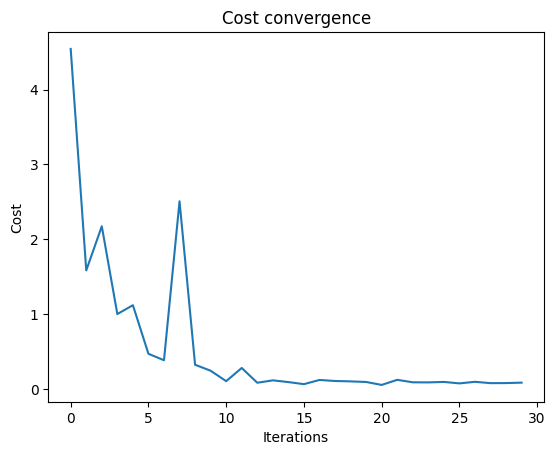

In [12]:
with tqdm(total=MAX_ITERATIONS, desc="Optimization Progress", leave=True) as pbar:

    def progress_bar(xk: np.ndarray) -> None:
        pbar.update(1)  # increment progress bar

    final_params = scipy.optimize.minimize(
        fun=lambda params: evaluate_params(es_X, es_Y, es_Z, params),
        x0=initial_params,
        method="COBYLA",
        options={"maxiter": MAX_ITERATIONS},
        callback=progress_bar,
    ).x.tolist()

print(f"Optimized parameters: {final_params}")
plt.plot(cost_trace)
plt.xlabel("Iterations")
plt.ylabel("Cost")
plt.title("Cost convergence")

In [13]:
es = ExecutionSession(qprog, execution_preferences=ExecutionPreferences(num_shots=1000))
res_qaoa = es.sample({"theta": final_params})
es.close()

## Define the function for extracting the predicted position from the quantum algorithm results

In [14]:
def estimate_arm_pos(params):
    X_sample = es_X.sample(parameters={"theta": params.tolist()})
    Y_sample = es_Y.sample(parameters={"theta": params.tolist()})
    Z_sample = es_Z.sample(parameters={"theta": params.tolist()})
    X0_expect, X1_expect = expected_valu(X_sample.counts)
    Y0_expect, Y1_expect = expected_valu(Y_sample.counts)
    Z0_expect, Z1_expect = expected_valu(Z_sample.counts)
    v0 = np.array([X0_expect, Y0_expect, Z0_expect])
    v1 = np.array([X1_expect, Y1_expect, Z1_expect])
    estimate_pos = L1 * v0 + L2 * v1
    return estimate_pos


estimate_arm_pos(np.array(final_params))

array([0.806, 1.216, 0.204])

In [15]:
print("predict_arm_position :", estimate_arm_pos(np.array(final_params)))
print("target_arm_position :", target_pos)

predict_arm_position : [0.79  1.202 0.142]
target_arm_position : [0.6 1.  0.2]


## Reference
<a id='QOA'>[1]</a>: [T. Otani, A. Takanishi, N. Hara, Y.Takita and K.Kimura. "Quantum computation for robot posture optimization." Scientific Reports volume 15, 28508 (2025).](https://www.nature.com/articles/s41598-025-12109-0)